При использовании многослойного персептрона вектор предложения представляет собой усредненные векторы для каждого слова.

📌 Какие минусы есть у этого подхода? Какую особенность текстовых данных он не позволяет учитывать?


**Рекуррентные нейронные сети (recurrent neural networks, RNN)** — это класс нейронных сетей, которые применяются для обработки последовательных данных.

## Ячейка рекуррентной нейронной сети

Мы будем последовательно обрабатывать каждое слово $x_t$ с помощью ячейки RNN.

rnn_unfolded.svg

1. На вход ячейки поступает входной вектор $x_t$ —  эмбеддинг слова с индексом $t$. Он имеет фиксированный размер $k$.

2. Ячейка принимает еще один параметр $h_{t-1}$ — **скрытое состояние** или **память** (hidden state). Это вектор, хранящий информацию о предшествующем контексте. Он тоже имеет фиксированный размер $n$.

3. Вектор $x_t$ умножается на матрицу $W^{nk}$ (размер $n \times k$), которая содержит обучаемые веса: $W^{nk} \cdot x_t$. Получаем новый вектор размера $n$.

4. Вектор $h_{t-1}$ умножается на другую матрицу весов $W^{nn}$ (размер $n \times n$): $ W^{nn} \cdot h_{t-1} $. Получаем новый вектор размера $n$.

5. Получившиеся векторы имеют одинаковый размер, их можно сложить: $W^{nk} \cdot x_t + W^{nn} \cdot h_{t-1}$.

6. К получившемуся вектору применим функцию активации — гиперболический тангенс: $tanh(W^{nk} \cdot x_t + W^{nn} \cdot h_{t-1})$. Это и будет новым скрытым состоянием $h_t$. Оно зависит от предыдущего состояния $h_{t-1}$ и текущего элемента последовательности $x_t$.

7. Рассчитанное скрытое состояние $h_t$ является представлением текущего слова $x_t$ с учетом предшествующего контекста и передается в качестве старого скрытого состояния для следующего слова $x_{t+1}$.


### Гиперболический тангенс

Гиперболический тангенс: $ tanh(x) = \large\frac{(e^x - e^{−x})}{(e^x + e^{-x})}$

```python
torch.nn.Tanh()
```

Входные данные: tensor([-0.5325, -0.2152,  0.1198,  ..., -0.2082,  0.4334, -2.1474])
Выходные данные: tensor([-0.4873, -0.2119,  0.1193,  ..., -0.2052,  0.4081, -0.9731])


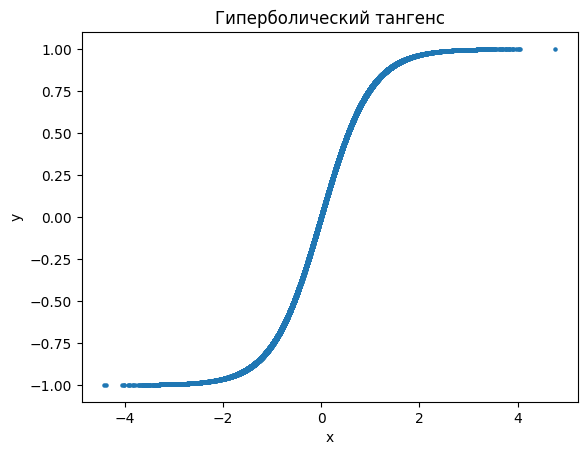

In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt

act = nn.Tanh()
input = torch.randn(100000)
print(f'Входные данные: {input}')
output = act(input)
print(f'Выходные данные: {output}')
plt.scatter(input, output, s=5);
plt.title("Гиперболический тангенс")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

- Чем больше (положительное) входное значение, тем ближе значение функции к 1;
- Чем меньше (отрицательное) входное значение, тем ближе значение функции к -1.

### Реализация ячейки RNN

Реализуем ячейку RNN самостоятельно.

📌 Допишите вычисление скрытого состояния по формуле:

$h = tanh(W^{nk} \cdot x_t + W^{nn} \cdot h_{t-1})$

In [2]:
class MyRNNCell(nn.Module):
  def __init__(self, input_size, hidden_size): # input_size — размер входного вектора x, hidden_size — размер вектора памяти h
    super().__init__()
    # инициализируем матрицы весов
    self.W_hx = torch.randn(hidden_size, input_size) # матрица весов для умножения на входной вектор
    self.W_hh = torch.randn(hidden_size, hidden_size) # матрица весов для умножения на вектор памяти
    self.h0 = torch.zeros((hidden_size)) # инициализация вектора памяти нулями для первого токена

  def forward(self, x, h=None):
    if h is None: # если вектор памяти не задан, инициализируем нулями
      h = self.h0
    act = nn.Tanh()
    h = act(self.W_hx @ x + self.W_hh @ h) # Место для вашего кода
    return h # возвращаем вектор памяти

In [3]:
x = torch.randn(5) # вектор 1 слова из 5 признаков
print(f"Входные данные: {x}")
print(f"Размер входных данных: {x.shape}")

Входные данные: tensor([ 0.8873, -1.7437,  0.7209, -0.1945,  0.1099])
Размер входных данных: torch.Size([5])


In [4]:
my_rnn_cell = MyRNNCell(input_size=5, hidden_size=3)
h = my_rnn_cell(x)
print(f"Выходные данные {h}")
print(f"Размер выходных данных: {h.shape}")

Выходные данные tensor([-0.9978, -0.8601,  0.5341])
Размер выходных данных: torch.Size([3])


Воспользуемся реализацией ячейки [RNNCell](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html) из pytorch.

In [5]:
torch_rnn_cell = nn.RNNCell(input_size=5, hidden_size=3)
h = torch_rnn_cell(x)
print(f"Выходные данные {h}")
print(f"Размер выходных данных: {h.shape}")

Выходные данные tensor([ 0.1428, -0.2209, -0.3402], grad_fn=<SqueezeBackward1>)
Размер выходных данных: torch.Size([3])


## Слой рекуррентной нейронной сети

Для обработки всей последовательности слов используется слой RNN, где ячейка применяется ко всем словам в цикле.

rnn_seq_to_seq.svg

Когда первый токен $x_0$ подается в ячейку, вектор памяти $h$ инициализируется нулями.

Вектор памяти $h_0$ для первого токена $x_0$ передается в следующую ячейку, обрабатывающую второй токен $x_1$. Вектор $h_0$ также является контекстуализированным представлением токена $x_0$ — $y_0$.

Для каждого последующего токена вектор памяти учитывает контекст из предыдущих токенов.

Вектор $y_t$ является не только контекстуализированным представлением для последнего токена $x_t$, но и вектором всего предложения, т.к. содержит информацию обо всех токенах.

В зависимости от типа задачи, можно использовать контекстуализированные вектора для каждого слова или только вектор всего предложения (последнего слова).

### Типы задач

- Один к одному: на вход подается один элемент, на выходе получаем вероятность класса — классификация изображений.

- Один ко многим: на вход приходит один элемент, а на выходе получаем целую последовательность — генерация текста по слову, текстовой подписи по изображению.

- Многие к одному: на вход сети подается последовательность, а в качестве выхода получаем один вектор вероятностей для классов — классификация текстов (анализ тональности, определение языка).

- Многие ко многим: преобразовать последовательность в последовательность
  - количество выходов равно количеству входов — тегирование (именованные сущности, части речи).
  - количество выходов сети не обязательно равно количеству входов — машинный перевод, суммаризация.

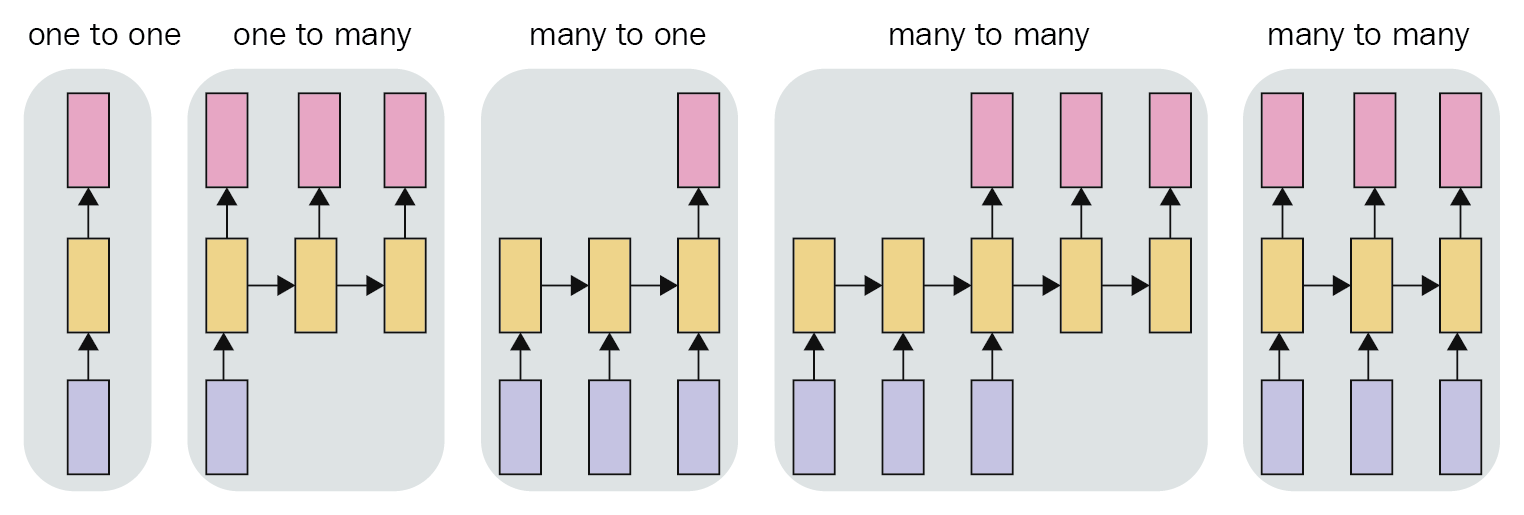

### Реализация слоя RNN

Реализуем слой RNN самостоятельно.

📌 Допишите вычисление скрытого состояния $h$, применив ячейку RNN.

In [6]:
import numpy as np

class MyRNNLayer(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.rnn_cell = MyRNNCell(input_size, hidden_size) # используем класс ячейки RNN

  def forward(self, x, h=None):
    all_h = [] # будем хранить все скрытые состояния
    for i in range(x.shape[0]): # проходим в цикле по всем токенам (строкам)
      h = self.rnn_cell(x[i], h) # Место для вашего кода
      all_h.append(h) # сохраняем скрытое состояние для текущего токена
    return  torch.Tensor(np.stack(all_h)), h # возвращаем все скрытые состояния и скрытое состояние последнего слова (всего предложения)

In [7]:
sequence = torch.randn(7, 5) # предложение из 7 токенов, у каждого 5 признаков
print(f"Входные данные:\n{sequence}")
print(f"Размер входных данных: {sequence.shape}")

Входные данные:
tensor([[-1.0306,  1.0590,  0.6247, -0.3167, -0.0195],
        [ 0.4384,  0.7607, -0.2405,  0.4219, -0.1226],
        [-1.1375,  0.5439, -0.8639,  0.6045, -0.2544],
        [-0.9029, -0.0353,  2.1907,  1.3778,  0.3116],
        [ 0.4085,  0.2305,  1.0625, -0.2174, -2.7970],
        [ 1.0120,  0.3405, -0.7649, -0.3707, -0.8141],
        [ 0.2946,  0.3328, -0.6505, -0.2545,  0.3910]])
Размер входных данных: torch.Size([7, 5])


In [8]:
my_rnn = MyRNNLayer(input_size=5, hidden_size=3)
out, h = my_rnn(sequence)

print(f"Выходные данные:\n{out}")
print(f"Размер выходных данных: {out.shape}\n")

print(f"Вектор предложения: {h}")
print(f"Размер вектора предложения: {h.shape}")

Выходные данные:
tensor([[ 0.8354,  0.5983,  0.5115],
        [-0.6294,  0.8513, -0.9870],
        [-0.9994, -0.1839, -0.9971],
        [ 0.9998, -0.9577,  0.9988],
        [ 0.9987,  0.9711,  1.0000],
        [-0.9063,  0.9618, -0.9497],
        [-0.6998, -0.7292, -0.9673]])
Размер выходных данных: torch.Size([7, 3])

Вектор предложения: tensor([-0.6998, -0.7292, -0.9673])
Размер вектора предложения: torch.Size([3])


Воспользуемся реализацией слоя [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) из pytorch.

In [9]:
rnn = nn.RNN(input_size=5, hidden_size=3)
out, h = rnn(sequence)

print(f"Выходные данные:\n{out}")
print(f"Размер выходных данных: {out.shape}\n")

print(f"Вектор предложения: {h}")
print(f"Размер вектора предложения: {h.shape}")

Выходные данные:
tensor([[-0.0809, -0.5614,  0.4402],
        [ 0.6511, -0.7841,  0.5629],
        [-0.0230, -0.6389, -0.4201],
        [ 0.7225,  0.7257,  0.6177],
        [ 0.3957, -0.9711, -0.1696],
        [ 0.6295, -0.9610,  0.1972],
        [-0.0289, -0.8429,  0.6041]], grad_fn=<SqueezeBackward1>)
Размер выходных данных: torch.Size([7, 3])

Вектор предложения: tensor([[-0.0289, -0.8429,  0.6041]], grad_fn=<SqueezeBackward1>)
Размер вектора предложения: torch.Size([1, 3])


### Двунаправленные рекуррентные сети

Двунаправленная рекуррентная сеть (Bidirectional Recurrent Neural Network, biRNN) включает две однонаправленные рекуррентные сети, одна из которых обрабатывает входную последовательность в прямом порядке, а другая — в обратном. Для каждого элемента входной последовательности считается два вектора скрытых состояний, на основе которых вычисляется выход сети.

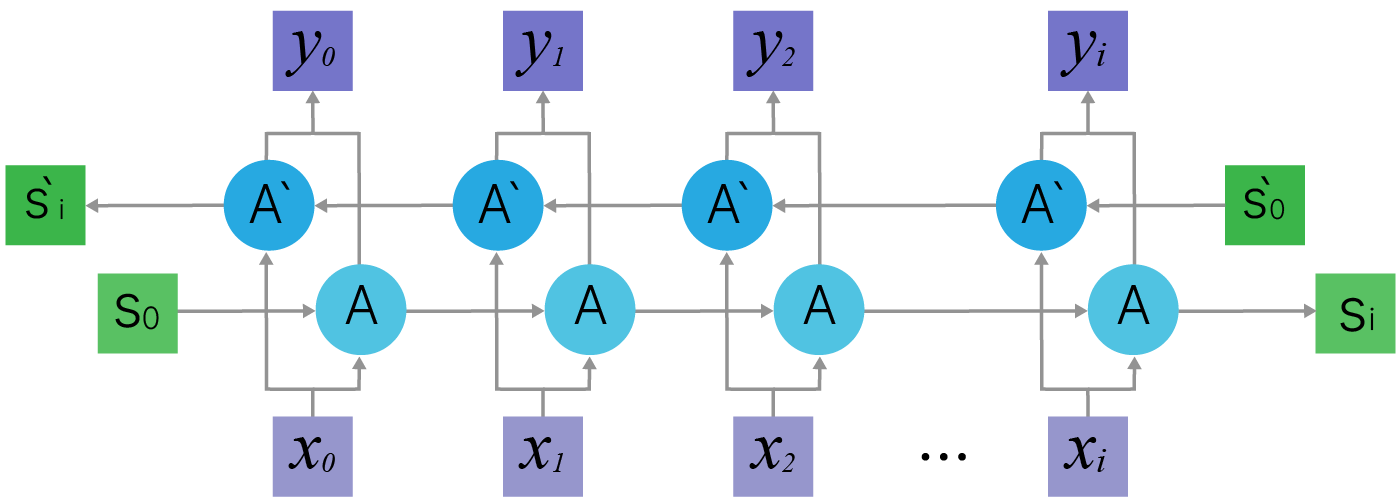

Становится доступна информация как о левом, так и о правом контексте.

- Предложение: Мама мыла раму
- Forward hidden state: мама мыла раму
- Backward hidden state: раму мыла мама

Реализуем слой двунаправленной RNN самостоятельно.

📌 Допишите вычисление скрытого состояния при прямом и обратном проходе по последовательности.

In [10]:
class MyBidirectionalRNNLayer(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.rnn_cell_forward = MyRNNCell(input_size, hidden_size) # используем класс ячейки RNN
    self.rnn_cell_backward = MyRNNCell(input_size, hidden_size) # используем класс ячейки RNN

  def forward(self, x, forward_h=None, backward_h=None):

    all_forward_h = [] # скрытые состояния при прямом проходе по последовательности
    all_backward_h = [] # скрытые состояния при обратном проходе по последовательности

    for i in range(x.shape[0]): # проходим в цикле по всем токенам (строкам)

      forward_h = self.rnn_cell_forward(x[i], forward_h) # Место для вашего кода
      backward_h = self.rnn_cell_backward(x[x.shape[0] - i - 1], backward_h) # Место для вашего кода

      all_forward_h.append(forward_h)
      all_backward_h.append(backward_h)

    all_forward_h = torch.Tensor(np.stack(all_forward_h))
    all_backward_h = torch.Tensor(np.stack(all_backward_h))

    forward_h = torch.unsqueeze(torch.Tensor(np.stack(all_forward_h[-1])), dim=0)
    backward_h = torch.unsqueeze(torch.Tensor(np.stack(all_backward_h[0])), dim=0)

    return torch.cat((all_forward_h, all_backward_h), dim=1), torch.cat((forward_h, backward_h), dim=0)

In [11]:
my_birnn = MyBidirectionalRNNLayer(input_size=5, hidden_size=3)
out, h = my_birnn(sequence)

print(f"Выходные данные:\n{out}")
print(f"Размер выходных данных: {out.shape}\n")

print(f"Вектор предложения:\n{h}")
print(f"Размер вектора предложения: {h.shape}")

Выходные данные:
tensor([[-0.9242, -0.8292, -0.6950,  0.0556, -0.2146,  0.2939],
        [-0.9884, -0.9746, -0.8941, -0.6212, -0.3736,  0.7697],
        [-0.5445, -0.9948, -0.9349, -0.8877, -0.9488,  0.9898],
        [ 0.8723, -0.9861,  0.8029,  0.3205, -0.3941,  0.8507],
        [ 0.8102, -0.1817, -0.9993, -0.2169,  0.9884, -0.9229],
        [-0.9718, -0.8336, -0.2883, -0.9499, -0.3383,  0.0226],
        [-0.9503, -0.9580, -0.9087, -0.3870, -0.9448,  0.9553]])
Размер выходных данных: torch.Size([7, 6])

Вектор предложения:
tensor([[-0.9503, -0.9580, -0.9087],
        [ 0.0556, -0.2146,  0.2939]])
Размер вектора предложения: torch.Size([2, 3])


Для реализации в pytorch нужно для [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) установить параметр `bidirectional=True`.

In [12]:
rnn = nn.RNN(input_size=5, hidden_size=3, bidirectional=True)
out, h = rnn(sequence)

print(f"Выходные данные:\n{out}")
print(f"Размер выходных данных: {out.shape}\n")

print(f"Вектор предложения:\n{h}")
print(f"Размер вектора предложения: {h.shape}")

Выходные данные:
tensor([[-0.6682, -0.9259,  0.8912, -0.8621, -0.0947,  0.7590],
        [-0.7521, -0.8608,  0.8921,  0.1551, -0.4284,  0.7039],
        [-0.8959, -0.9331,  0.9727,  0.1704, -0.0761,  0.2619],
        [ 0.1365, -0.4486,  0.4246, -0.6555,  0.7653, -0.5582],
        [ 0.8074, -0.5200, -0.6294, -0.3286, -0.2220,  0.8868],
        [-0.4670, -0.8517,  0.6190,  0.4072, -0.3818,  0.8993],
        [-0.8509, -0.8723,  0.9542, -0.0551, -0.4992,  0.5309]],
       grad_fn=<SqueezeBackward1>)
Размер выходных данных: torch.Size([7, 6])

Вектор предложения:
tensor([[-0.8509, -0.8723,  0.9542],
        [-0.8621, -0.0947,  0.7590]], grad_fn=<SqueezeBackward1>)
Размер вектора предложения: torch.Size([2, 3])


## Алгоритм обратного распространения ошибки сквозь время

Обучение RNN аналогично обучению обычной нейронной сети. Мы также используем алгоритм обратного распространения ошибки (backpropagation), но с небольшим изменением.

Градиент на каждом выходе зависит не только от расчетов текущего шага, но и от предыдущих временных шагов. Вектор памяти для $h_3$ зависит от вектора памяти $h_2$, $h_1$ и $h_0$. Следовательно, чтобы вычислить градиент для $h_3$, нужно распространить ошибку на 3 шага и суммировать градиенты.

Этот алгоритм называется «алгоритмом обратного распространения ошибки сквозь время» (Backpropagation Through Time, BPTT).

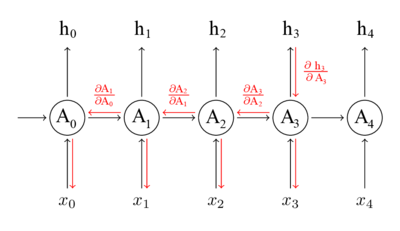

$$\frac{\partial L}{\partial W} = \sum\limits_{i=0}^t\frac{\partial L_i}{\partial W}$$
$$\frac{\partial L_t}{\partial W} = \frac{\partial L_t}{\partial \hat y} \frac{\partial \hat y}{\partial h_t} \frac{\partial h_t}{\partial W} $$

$$h_t = tanh(Vx_t + Wh_{t-1})$$

$$\frac{\partial L_t}{\partial W} = \frac{\partial L_t}{\partial \hat y_t} \frac{\partial \hat y_t}{\partial h_t} (\frac{\partial h_t}{\partial W} + \frac{\partial h_t}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial W} + \cdots)  = \frac{\partial L_t}{\partial \hat y_t} \frac{\partial \hat y_t}{\partial h_t}\sum\limits_{k=0}^t (\prod\limits_{i = k+1}^t \frac{\partial h_i}{\partial h_{i-1}}) \frac{\partial h_k}{\partial W}$$

$\large \| \frac{\partial h_i}{\partial h_{i-1}} \| \lt 1 $ — затухающий градиент (vanishing gradient)

$\large \| \frac{\partial h_i}{\partial h_{i-1}} \| \gt 1 $ — взрывающийся градиент (exploding gradient)

Борьба с взрывающимся градиентом — **градиентное отсечение** (gradient clipping) — метод, который ограничивает максимально допустимое значение градиента, позволяя избежать градиентного взрыва.

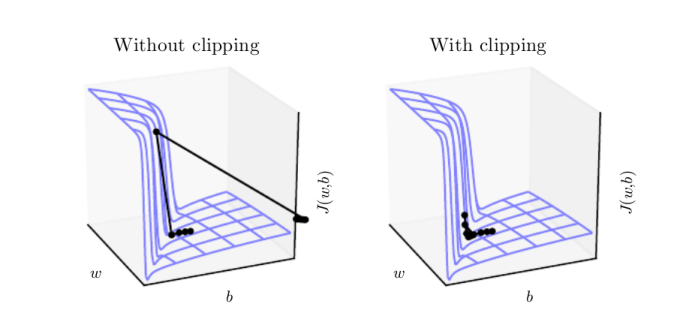

От затухания и взрыва градиента может помочь **пропускание градиента по частям** (truncated gradient) на сколько-то шагов по времени назад, а не через всю нейросеть.

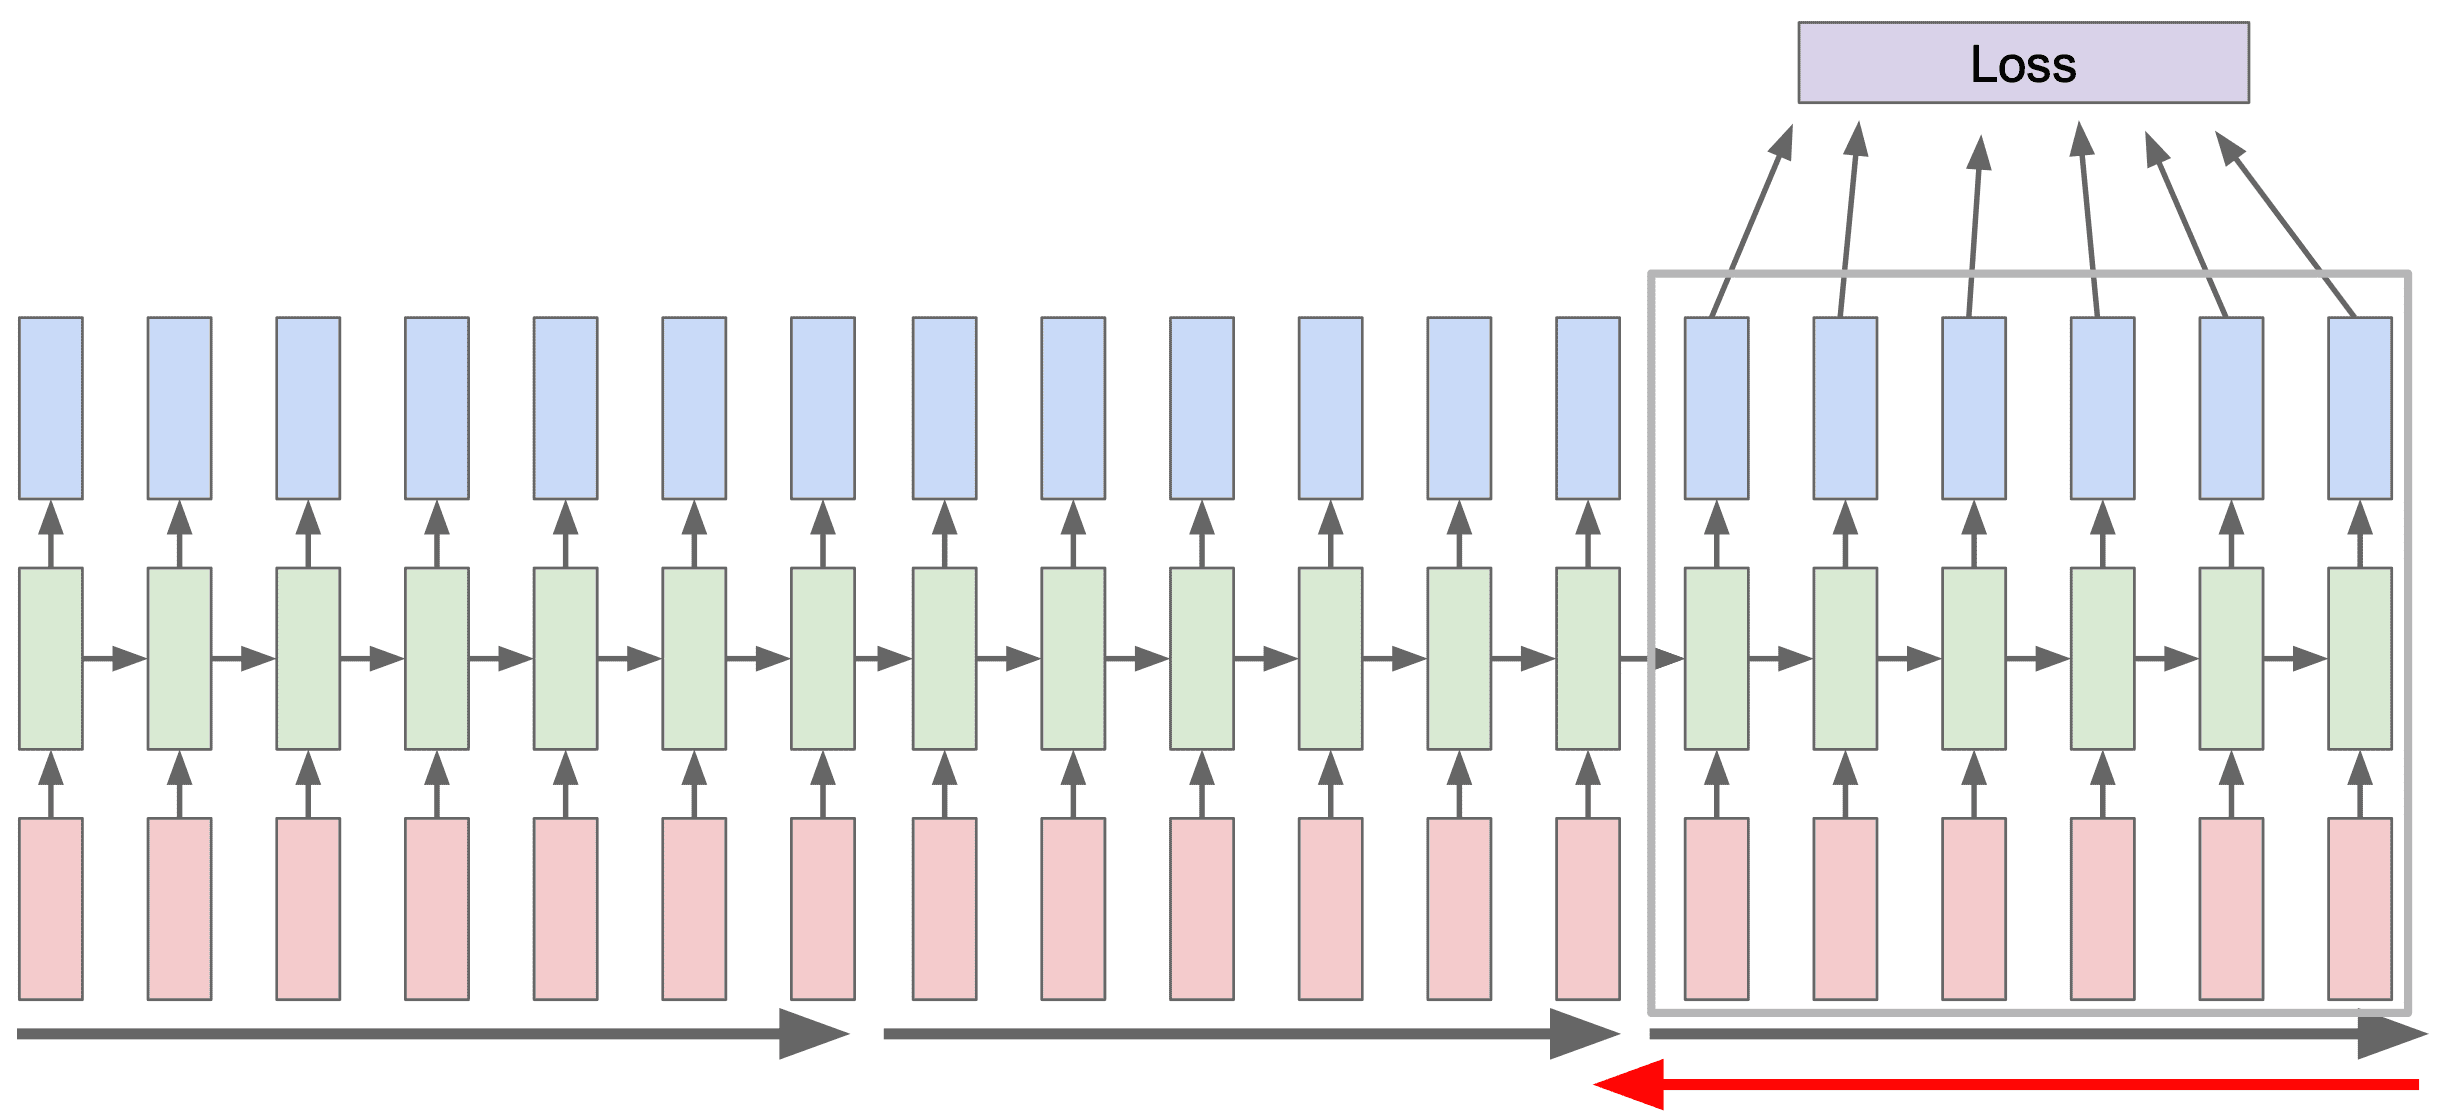

Минусы классических рекуррентных сетей:
- информация о начальных словах затухает к концу предложения
- затухающие и взрывающиеся градиенты


## Сети долгой краткосрочной памяти

В обычной RNN в ячейке был только один путь передачи информации. На каждом шаге мы складывали информацию, накопленную с предыдущих шагов, с текущей. При этом информация о предыдущих токенах быстро затухает, и теряется общая информация о предложении.

Эта проблема были решена в сети долгой краткосрочной памяти (Long short-term memory, LSTM). Структура ячейки LSTM намного сложнее. Здесь есть целых 4 линейных слоя, каждый из которых выполняет разные задачи.

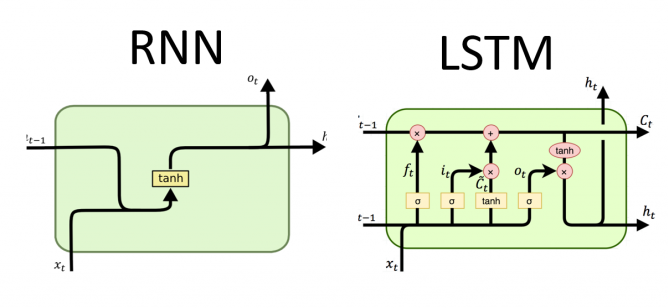

Главное нововведение: в LSTM добавлено состояние $c_t$, которое должно сохранять общий контекст. Помогает нейросети сохранять важную информацию, встретившуюся в какой-то момент в предложении, все время, пока эта информация требуется.

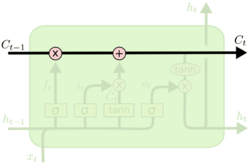

### Структура ячейки LSTM

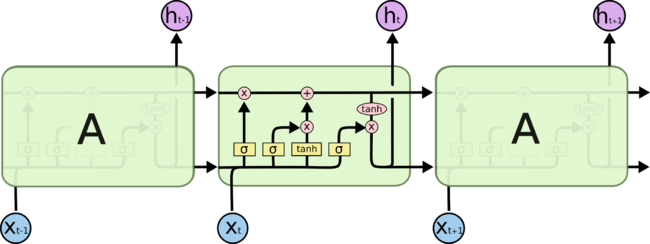

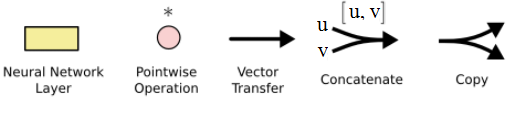

$h_{t-1}$ — вектор краткосрочной памяти для предшествующего контекста;

$c_{t-1}$ — вектор долгой памяти для предшествующего контекста;

$x_t$ — вектор текущего токена;

$h_t$ — вектор краткосрочной памяти для контекста с учетом текущего токена;

$c_t$ — вектор долгой памяти для контекста с учетом текущего токена;

$W_f, W_i, W_c, W_o$ — матрицы параметров;

$σ,\;tanh$ — функции активации.

$ f_t = σ(W_f \cdot [h_{t-1}, x_t])$ — вентиль забывания (forget gate), вес забывания старой информации.

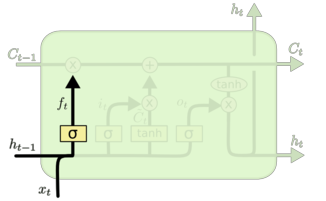

$ i_t = σ(W_i \cdot [h_{t-1}, x_t])$ — входной вентиль (input gate), вес запоминания новой информации;

$ \tilde c_t = \tanh(W_c \cdot [h_{t-1}, x_t])$ — предварительный вектор долгой памяти (candidate cell state), содержание новой информации.

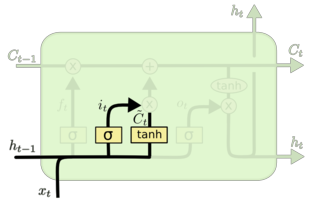

$ c_t = f_t\otimes c_{t-1} + i_t \otimes \tilde c_t$ — обновленный вектор долгой памяти.

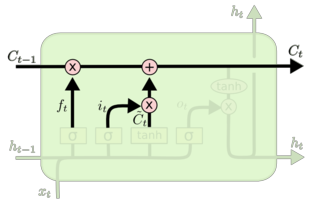

$ o_t = σ(W_o \cdot [h_{t-1}, x_t])$ — выходной вентиль для текущего токена (output gate);

$ h_t = o_t\otimes \tanh(C_t)$ — обновленный вектор краткосрочной памяти.

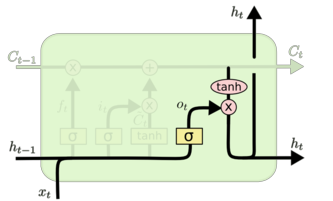

### Реализация ячейки LSTM

Реализуем ячейку LSTM самостоятельно. Отличие от RNN состоит в том, что кроме $h$ возвращается еще и $c$.

📌 Допишите вычисление для векторов $f, i, \tilde c, c, o, h$ по формулам.

In [13]:
class MyLSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size): # input_size — размер входного вектора x, hidden_size размер векторов памяти h и c
    super().__init__()

    # инициализируем матрицы весов
    self.W_f = torch.randn(hidden_size, hidden_size + input_size) # матрица весов для вентиля забывания f
    self.W_i = torch.randn(hidden_size, hidden_size + input_size) # матрица весов для входного вентиля i
    self.W_c = torch.randn(hidden_size, hidden_size + input_size) # матрица весов для предварительного вектора долгой памяти c_tilde
    self.W_o = torch.randn(hidden_size, hidden_size + input_size) # матрица весов для выходного вентиля o
    self.h0 = torch.zeros((hidden_size)) # инициализация вектора краткосрочной памяти h нулями для первого токена
    self.c0 = torch.zeros((hidden_size)) # инициализация вектора долгой памяти c нулями для первого токена

  def forward(self, x, h=None, c=None):

    if h is None: # если вектор краткосрочной памяти h не задан, инициализируем нулями
      h = self.h0
    if c is None: # если вектор долгой памяти c не задан, инициализируем нулями
      c = self.c0

    h_x_cat = torch.cat((h,x)) # конкатенация вектора краткосрочной памяти h и вектора текущего токена x

    sigmoid = nn.Sigmoid() # определяем функции активации
    tanh = nn.Tanh()

    f = sigmoid(self.W_f @ h_x_cat) # Место для вашего кода
    i = sigmoid(self.W_i @ h_x_cat) # Место для вашего кода
    c_tilde = tanh(self.W_c @ h_x_cat) # Место для вашего кода
    c = f * c + i * c_tilde # Место для вашего кода
    o = sigmoid(self.W_o @ h_x_cat) # Место для вашего кода
    h = o * tanh(c) # Место для вашего кода

    return h, c # возвращаем векторы памяти

In [14]:
x = torch.randn(6) # вектор 1 слова из 6 признаков
print(f"Входные данные: {x}")
print(f"Размер входных данных: {x.shape}")

Входные данные: tensor([ 0.0501,  0.0507, -0.7932,  0.7562, -2.0085,  1.1408])
Размер входных данных: torch.Size([6])


In [15]:
my_lstm_cell = MyLSTMCell(input_size=6, hidden_size=5)
h,c = my_lstm_cell(x)
print(f"Вектор краткосрочной памяти:\n{h}")
print(f"Размер вектора краткосрочной памяти: {h.shape}\n")
print(f"Вектор долгой памяти:\n{c}")
print(f"Размер вектора долгой памяти: {c.shape}")

Вектор краткосрочной памяти:
tensor([0.3932, 0.0156, 0.0086, 0.0426, 0.1196])
Размер вектора краткосрочной памяти: torch.Size([5])

Вектор долгой памяти:
tensor([0.9627, 0.0219, 0.0089, 0.1944, 0.1219])
Размер вектора долгой памяти: torch.Size([5])


Воспользуемся реализацией ячейки [LSTMCell](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html) из pytorch. Интерфейс отличается от RNNCell количеством входов и выходов.

In [16]:
lstm_cell = torch.nn.LSTMCell(input_size=6, hidden_size=5)
h, c = lstm_cell(x)
print(f"Вектор краткосрочной памяти:\n{h}")
print(f"Размер вектора краткосрочной памяти: {h.shape}\n")
print(f"Вектор долгой памяти:\n{c}")
print(f"Размер вектора долгой памяти: {c.shape}")

Вектор краткосрочной памяти:
tensor([-0.3062,  0.0405,  0.1486, -0.1394,  0.0202],
       grad_fn=<SqueezeBackward1>)
Размер вектора краткосрочной памяти: torch.Size([5])

Вектор долгой памяти:
tensor([-0.4103,  0.1604,  0.2285, -0.3723,  0.0425],
       grad_fn=<SqueezeBackward1>)
Размер вектора долгой памяти: torch.Size([5])


### Реализация слоя LSTM

Реализуем слой LSTM самостоятельно.

📌 Допишите вычисление скрытых состояний  $h$ и $c$, применив ячейку LSTM.

In [17]:
class MyLSTMLayer(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.lstm_cell = MyLSTMCell(input_size, hidden_size) # используем класс ячейки RNN

  def forward(self, x, h=None, c=None):
    all_h = [] # будем хранить все скрытые состояния
    for i in range(x.shape[0]): # проходим в цикле по всем токенам (строкам)
      h, c = self.lstm_cell(x[i], h, c) # Место для вашего кода
      all_h.append(h) # сохраняем скрытое состояние для текущего токена
    return  torch.Tensor(np.stack(all_h)), (h, c) # возвращаем все скрытые состояния и скрытое состояние последнего слова (всего предложения)

In [18]:
sequence = torch.randn(4, 6) # предложение из 4 токенов, у каждого 6 признака
print(f"Входные данные:\n{sequence}")
print(f"Размер входных данных: {sequence.shape}")

Входные данные:
tensor([[-0.6600,  1.8409,  0.1671,  0.2701,  0.2280, -0.2922],
        [-0.5211,  1.1335,  0.1363,  0.3173,  0.5445, -1.1453],
        [-0.7937, -0.7123, -0.3273, -0.7314, -2.1177,  1.3733],
        [-0.9146, -0.7455, -1.0013,  0.3790,  0.3703,  1.3922]])
Размер входных данных: torch.Size([4, 6])


In [19]:
my_lstm = MyLSTMLayer(input_size=6, hidden_size=5)
out, (h, c) = my_lstm(sequence)

print(f"Выходные данные (краткосрочная память):\n{out}")
print(f"Размер выходных данных: {out.shape}\n")

print(f"Вектор краткосрочной памяти всего предложения:\n{h}")
print(f"Размер вектора краткосрочной памяти: {h.shape}\n")

print(f"Вектор долгой памяти всего предложения:\n{c}")
print(f"Размер вектора долгой памяти: {c.shape}")

Выходные данные (краткосрочная память):
tensor([[ 0.1282, -0.6774, -0.2623, -0.0590,  0.0570],
        [ 0.4355, -0.5534, -0.3090, -0.1665,  0.0035],
        [ 0.0011,  0.0015, -0.0654, -0.1341, -0.4787],
        [-0.0061,  0.1272, -0.1088,  0.1235, -0.6565]])
Размер выходных данных: torch.Size([4, 5])

Вектор краткосрочной памяти всего предложения:
tensor([-0.0061,  0.1272, -0.1088,  0.1235, -0.6565])
Размер вектора краткосрочной памяти: torch.Size([5])

Вектор долгой памяти всего предложения:
tensor([-0.0241,  0.2640, -0.2465,  0.8318, -0.9596])
Размер вектора долгой памяти: torch.Size([5])


Воспользуемся реализацией слоя [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) из pytorch.

In [20]:
lstm = nn.LSTM(input_size=6, hidden_size=5)
out, (h, c) = lstm(sequence)

print(f"Выходные данные (краткосрочная память):\n{out}")
print(f"Размер выходных данных: {out.shape}\n")

print(f"Вектор краткосрочной памяти всего предложения:\n{h}")
print(f"Размер вектора краткосрочной памяти: {h.shape}\n")

print(f"Вектор долгой памяти всего предложения:\n{c}")
print(f"Размер вектора долгой памяти: {c.shape}")

Выходные данные (краткосрочная память):
tensor([[ 0.0663,  0.0158,  0.0356, -0.0679, -0.1943],
        [ 0.0549, -0.0014,  0.0854, -0.1060, -0.2533],
        [ 0.1159,  0.2513,  0.0837, -0.4722,  0.0498],
        [ 0.4216,  0.0723, -0.0197, -0.3053, -0.0329]],
       grad_fn=<SqueezeBackward1>)
Размер выходных данных: torch.Size([4, 5])

Вектор краткосрочной памяти всего предложения:
tensor([[ 0.4216,  0.0723, -0.0197, -0.3053, -0.0329]],
       grad_fn=<SqueezeBackward1>)
Размер вектора краткосрочной памяти: torch.Size([1, 5])

Вектор долгой памяти всего предложения:
tensor([[ 0.6237,  0.4328, -0.0687, -0.5005, -0.0514]],
       grad_fn=<SqueezeBackward1>)
Размер вектора долгой памяти: torch.Size([1, 5])
